# Table of Contents

* [Importing Libraries](#1)
* [Load Dataset](#2)
* [Data Visualization](#3)
* [Text Preprocessing](#4)
* [Building Model with Tensorflow](#5)
* [Prediction](#6)

In [1]:
# nltk is one of the most useful libraries when it comes to nlp
!pip install nltk

<a id="1"></a>
# Importing Libraries

In [2]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<a id="1"></a>
# Load Dataset

In [84]:
df = pd.read_csv('../input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


As you can see from above details, there is **no null values** in this dataset

<a id="3"></a>
# Data Visualization

Text(0.5, 1.0, 'Rating Distribution Across Dataset')

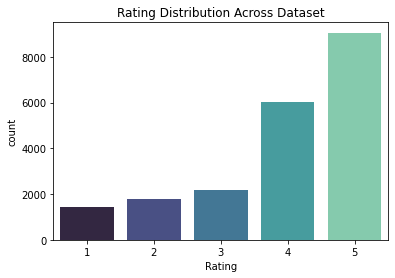

In [92]:
sns.countplot(data=df, x='Rating', palette='mako').set_title('Rating Distribution Across Dataset')

In [86]:
# Length of word in sentence
df['Length'] = df['Review'].apply(len)
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


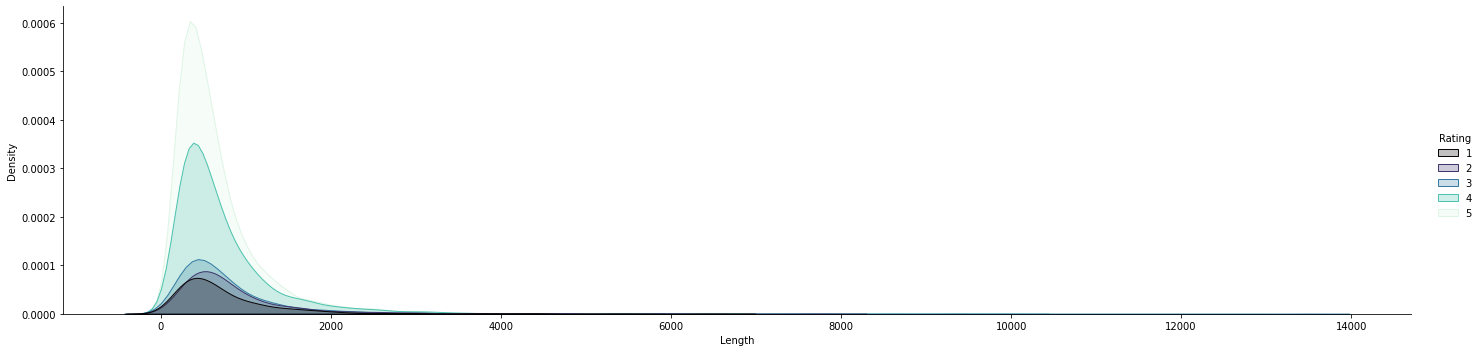

In [87]:
sns.displot(data=df, x='Length', hue='Rating', palette='mako', kind='kde', fill=True, aspect=4)

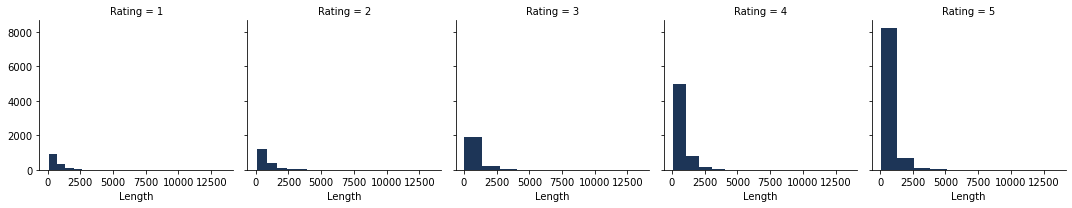

In [90]:
g = sns.FacetGrid(data=df, col='Rating')
g.map(plt.hist, 'Length', color='#1D3557')

<AxesSubplot:xlabel='Rating', ylabel='Length'>

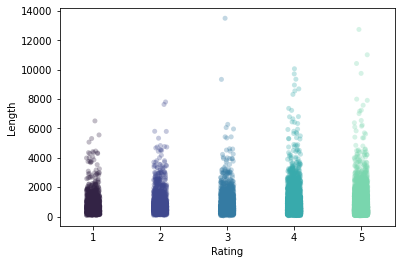

In [91]:
sns.stripplot(data=df, x='Rating', y='Length', palette='mako', alpha=0.3)

From above plot we can say that **the higher the rating of the hotel, the more likely the visitors wrote a long review**

<a id="4"></a>
# Text Preprocessing

In [93]:
# Let's change the rating to be more general and easier to understand
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Netral'
    else:
        return 'Bad'

In [94]:
df['Rating'] = df['Rating'].apply(rating)

In [95]:
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,Good,593
1,ok nothing special charge diamond member hilto...,Bad,1689
2,nice rooms not 4* experience hotel monaco seat...,Netral,1427
3,"unique, great stay, wonderful time hotel monac...",Good,600
4,"great stay great stay, went seahawk game aweso...",Good,1281


In [96]:
# Total word in dataset before cleaning
length = df['Length'].sum()

### Stemming vs Lemmatization
I think this picture can give you a sense of what is the different between stemming and lemmatization

![image](https://lh3.googleusercontent.com/BP5TVAfMRDWXufbDRorQs0s84WXcrmYEuru1tLrSBOd_xTtv06f2qld5VMXIvA_Y0iqeG__w0iXsTeZj9fSpocIx7eEZSqbY_gDihdIAHwuqlPSK244_IfK9tXaow3-Y3ftpW5WxEJ_58Meukw)

In [98]:
print('Original:')
print(df['Review'][0])
print()

sentence = []
for word in df['Review'][0].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Review'][0].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  

Stemming:
nice hotel expens park got good deal stay hotel anniversary, arriv late even took advic previous review did valet parking, check quick easy, littl disappoint non-exist view room room clean nice size, bed comfort woke stiff neck high pillows, not soundproof like heard music room night morn loud bang door open close hear peopl talk hallway, mayb just noisi neighbors, aveda bath produc

There are some difference among those 3 sentences, for instance:
* Original -> got, arrived
* Stemming -> got, arriv
* Lemmatization -> get, arrive

This time, we will use Lemmatization in order to get the base form of the word

In [99]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [100]:
df['Review'] = df['Review'].apply(cleaning)

In [101]:
df['Length'] = df['Review'].apply(len)
new_length = df['Length'].sum()

print('Total word before cleaning: {}'.format(length))
print('Total word after cleaning: {}'.format(new_length))

Total word before cleaning: 14853861
Total word after cleaning: 13543965


<a id="5"></a>
# Building Model with Tensorflow

In [102]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.2)

In [104]:
tokenizer = Tokenizer(oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq)

# One hot encoding the label
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train)
test_labels = lb.transform(y_test)

Total distinct words: 65183


In [105]:
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(16),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 8)           521464    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 32)                3200      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 51        
Total params: 525,243
Trainable params: 525,243
Non-trainable params: 0
________________________________________________

In [106]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_padded, train_labels, epochs=25, validation_data=(test_padded, test_labels))

Epoch 1/25
513/513 [==============================] - 64s 119ms/step - loss: 0.8969 - accuracy: 0.7000 - val_loss: 0.7487 - val_accuracy: 0.7407
Epoch 2/25
513/513 [==============================] - 59s 116ms/step - loss: 0.7808 - accuracy: 0.7343 - val_loss: 0.6681 - val_accuracy: 0.7407
Epoch 3/25
513/513 [==============================] - 60s 116ms/step - loss: 0.6392 - accuracy: 0.7425 - val_loss: 0.5382 - val_accuracy: 0.7577
Epoch 4/25
513/513 [==============================] - 60s 116ms/step - loss: 0.5372 - accuracy: 0.7912 - val_loss: 0.5403 - val_accuracy: 0.8021
Epoch 5/25
513/513 [==============================] - 60s 116ms/step - loss: 0.5028 - accuracy: 0.8023 - val_loss: 0.4879 - val_accuracy: 0.8151
Epoch 6/25
513/513 [==============================] - 60s 117ms/step - loss: 0.4543 - accuracy: 0.8358 - val_loss: 0.4724 - val_accuracy: 0.8246
Epoch 7/25
513/513 [==============================] - 60s 116ms/step - loss: 0.4228 - accuracy: 0.8480 - val_loss: 0.4637 - val_ac

<AxesSubplot:>

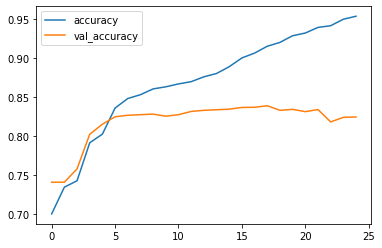

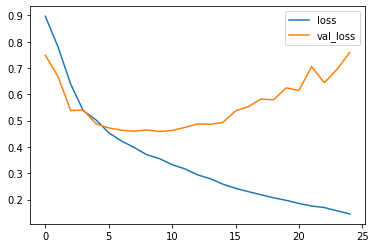

In [107]:
metrics = pd.DataFrame(model.history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

<a id="6"></a>
# Prediction

Let's make some prediction using the model we have trained. You can create your own reviews and let the model predict the sentiment in your text

In [108]:
def predict(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq)

    pred = model.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

In [109]:
text = 'Such a comfy place to stay with the loved one'
predict(text)

'Good'

In [110]:
text2 = 'Awful room services and slow wifi connection'
predict(text2)

'Bad'

In [111]:
text3 = 'Hard to get here but the scenery is wonderful'
predict(text3)

'Netral'

#### If you find this notebook useful, please upvote👍
#### Thanks